In [1]:
# 确保所有必需的库都已安装
# 注意：在 Notebook 中运行 shell 命令需要在前面加上 !
!pip install jieba matplotlib pandas numpy networkx

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install snownlp

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# 1. 安装 SnowNLP 库
# SnowNLP 自带情感分析功能，无需分词和自定义词典。
!pip install snownlp matplotlib pandas numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


--- 正在提取关键场景文本 ---
✅ 成功提取 '初夜之役' (章节 9-10)，文本长度: 18011 字。
✅ 成功提取 '晴天霹雳' (章节 35-35)，文本长度: 3042 字。
✅ 成功提取 '审判' (章节 41-41)，文本长度: 4692 字。

--- 正在生成情感分析结果和曲线 ---


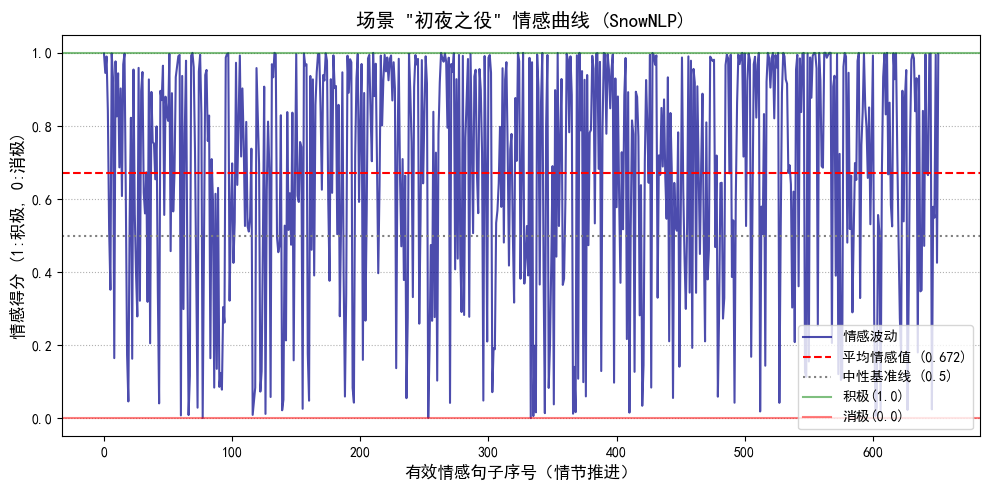


✅ 场景 '初夜之役' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.6715 (高于 0.5 倾向积极)


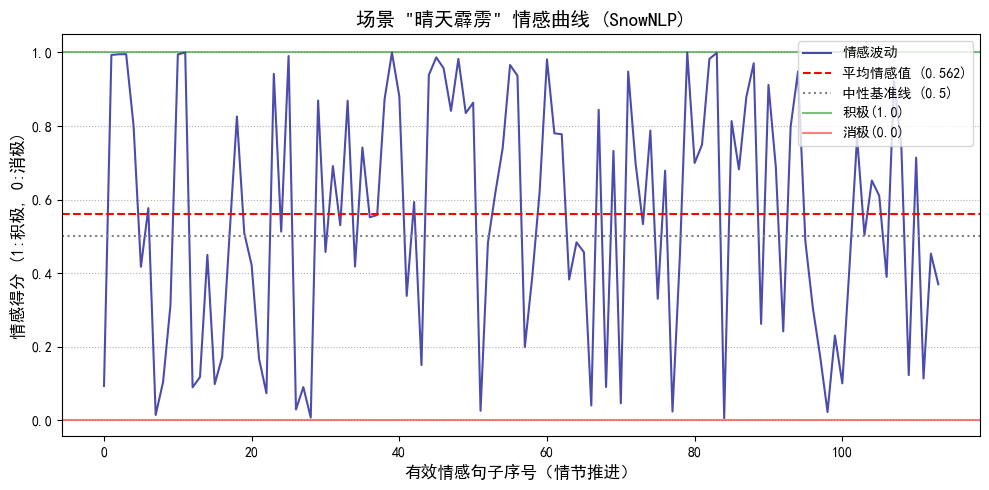


✅ 场景 '晴天霹雳' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.5617 (高于 0.5 倾向积极)


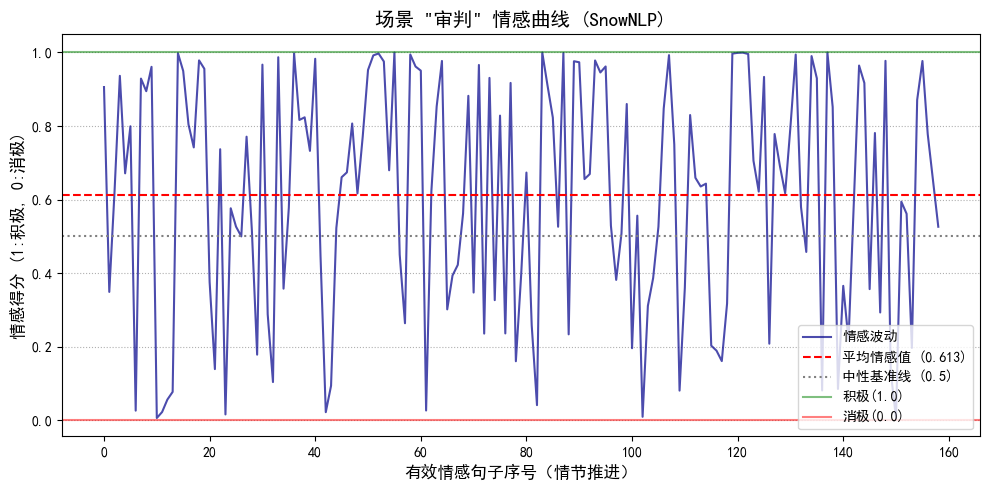


✅ 场景 '审判' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.6133 (高于 0.5 倾向积极)


In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from snownlp import SnowNLP # 导入 SnowNLP

# 确保文件路径正确。现在文件已在同一目录下，只需文件名。
file_path = 'hong_yu_hei_chapters_cleaned.csv' 

# --- 1. 设置绘图参数 ---
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'FangSong'] 
plt.rcParams['axes.unicode_minus'] = False 

# --- 2. SnowNLP 情感计算函数 ---
def calculate_sentence_sentiment_snownlp(text):
    """使用 SnowNLP 计算情感得分 (0 到 1 之间)"""
    if not text: 
        return None
    
    # SnowNLP 情感得分越高 (接近 1)，表示越积极
    s = SnowNLP(text)
    return s.sentiments

# --- 3. 分析与绘图函数 ---
def analyze_and_plot_scene(scene_name, text):
    if not text:
        print(f"无法分析场景 '{scene_name}'，文本为空。")
        return None

    # 按句切分
    sentences = re.split(r'[。？！；]', text)
    scores = []
    
    for sentence in sentences:
        score = calculate_sentence_sentiment_snownlp(sentence)
        if score is not None: 
            scores.append(score)
    
    if not scores:
        print(f"场景 '{scene_name}' 中未分析到任何有效句子。")
        return None

    avg_score = np.mean(scores)
    
    # 绘图可视化 (情感得分范围 0-1)
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='情感波动', color='darkblue', alpha=0.7)
    plt.axhline(avg_score, color='red', linestyle='--', label=f'平均情感值 ({avg_score:.3f})')
    plt.axhline(0.5, color='gray', linestyle=':', label='中性基准线 (0.5)')
    plt.axhline(1.0, color='green', linestyle='-', alpha=0.5, label='积极(1.0)')
    plt.axhline(0.0, color='red', linestyle='-', alpha=0.5, label='消极(0.0)')
    
    plt.title(f'场景 "{scene_name}" 情感曲线 (SnowNLP)', fontsize=14)
    plt.xlabel('有效情感句子序号（情节推进）', fontsize=12)
    plt.ylabel('情感得分 (1:积极, 0:消极)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
    plt.show() 
    
    print(f"\n✅ 场景 '{scene_name}' 小说情感分析结果：")
    print(f"   - 场景平均情感得分 (SnowNLP): {avg_score:.4f} (高于 0.5 倾向积极)")
    
    return avg_score

# --- 4. 提取与运行主流程 ---
try:
    df = pd.read_csv(file_path)
    df['章节编号'] = pd.to_numeric(df['章节编号'], errors='coerce')
    df = df.dropna(subset=['章节编号'])
    df['文本长度'] = df['清洗后文本'].astype(str).apply(len)
    content_df = df[df['文本长度'] > 100]

    # 最终确定的三个场景的提取参数
    scene_params_final = {
        '初夜之役': {'卷名': '上卷', '范围': (9, 10)}, 
        '晴天霹雳': {'卷名': '下卷', '范围': (35, 35)}, 
        '审判': {'卷名': '下卷', '范围': (41, 41)}     
    }

    extracted_scenes = {}
    print("--- 正在提取关键场景文本 ---")
    for scene_name, params in scene_params_final.items():
        juan_name = params['卷名']
        start_chap, end_chap = params['范围']
        
        scene_df = content_df[
            (content_df['卷名'] == juan_name) & 
            (content_df['章节编号'] >= start_chap) & 
            (content_df['章节编号'] <= end_chap)
        ]
        
        clean_text_list = scene_df['清洗后文本'].astype(str).tolist()
        clean_text_list = [t for t in clean_text_list if t != 'nan' and t != '']
        full_text = ' '.join(clean_text_list)
        extracted_scenes[scene_name] = full_text
        
        if full_text:
            print(f"✅ 成功提取 '{scene_name}' (章节 {start_chap}-{end_chap})，文本长度: {len(full_text)} 字。")
        else:
            print(f"❌ 失败提取 '{scene_name}'，请检查章节编号是否正确。")


    print("\n--- 正在生成情感分析结果和曲线 ---")
    for scene_name, text in extracted_scenes.items():
        analyze_and_plot_scene(scene_name, text)

except FileNotFoundError:
    print(f"\n❌ 错误：找不到文件 '{file_path}'。请确保 CSV 文件与你的 Jupyter Notebook 在同一个目录下。")
except Exception as e:
    print(f"\n❌ 运行过程中发生错误: {e}")

--- 正在进行全人物文本提取与情感分析 ---
✅ 文本提取完成。

✅ 结果已成功保存到文件: character_sentiment_results.csv

--- 情感分析最终结果预览 ---
     人物名称  平均情感得分  提及句数
0      于连  0.6455  2020
1   瑞纳尔夫人  0.6883  1085
2    玛蒂尔德  0.4869   116
3  德拉莫尔侯爵  0.6944   236
4   瓦莱诺先生  0.5153    84
5   比拉尔神父  0.5000     0
6      富凯  0.5000     0


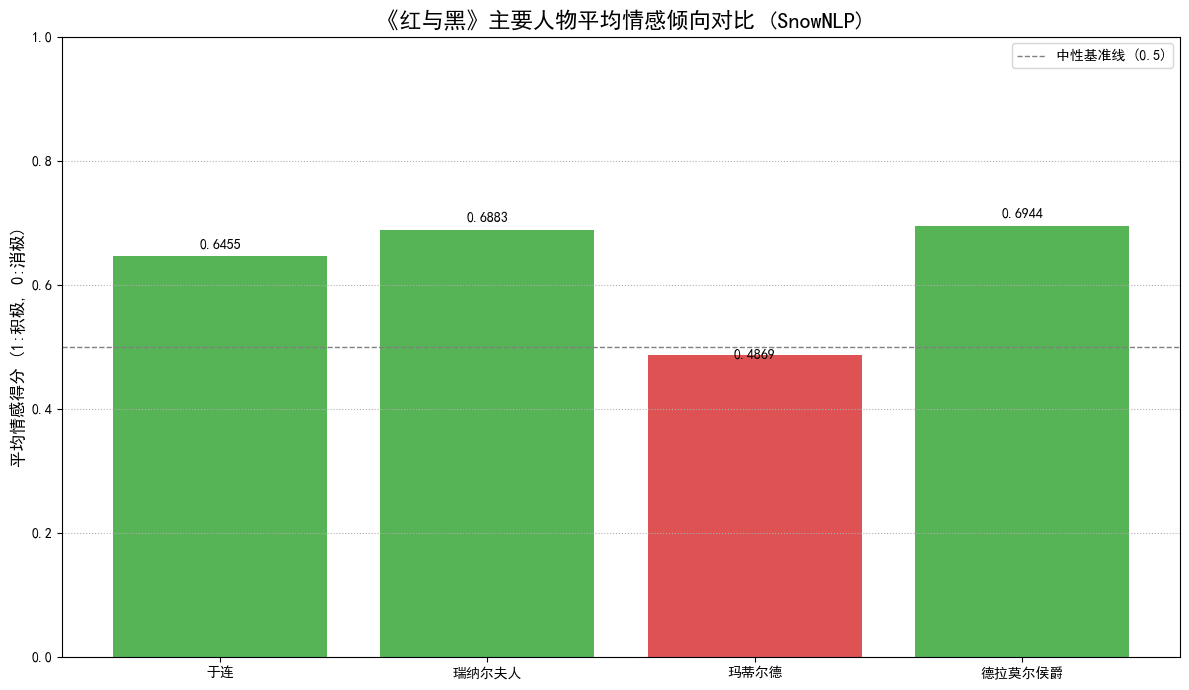

In [1]:
import pandas as pd
import numpy as np
import re
from snownlp import SnowNLP
import matplotlib.pyplot as plt

# --- 文件路径和设置 ---
file_path = 'hong_yu_hei_chapters_cleaned.csv' 
output_file = 'character_sentiment_results.csv'

# 设置中文显示，防止 Matplotlib 乱码
plt.rcParams['font.sans-serif'] = ['SimHei', 'FangSong'] 
plt.rcParams['axes.unicode_minus'] = False 

# --- 定义核心人物和别名 ---
CHARACTER_NAMES = {
    "于连": ["于连", "朱利安", "索莱尔", "红衣主教", "年轻人"],
    "瑞纳尔夫人": ["瑞那尔夫人", "德瑞纳尔夫人", "德瑞纳尔", "她"],
    "玛蒂尔德": ["玛蒂尔德", "马蒂尔德", "德拉莫尔小姐", "小姐"],
    "德拉莫尔侯爵": ["侯爵", "德拉莫尔", "老爷"],
    "瓦莱诺先生": ["瓦莱诺", "市长", "瓦尔诺"],
    "比拉尔神父": ["比拉尔神父", "比拉尔"],
    "富凯": ["富凯", "福盖"]
}

# 情感计算函数
def calculate_sentence_sentiment_snownlp(text):
    if not text or len(text) < 5: 
        return None
    s = SnowNLP(text)
    return s.sentiments

# --- 1. 提取与分析主流程 ---
try:
    df = pd.read_csv(file_path)
    df['清洗后文本'] = df['清洗后文本'].astype(str)
    
    full_text = ' '.join(df['清洗后文本'].tolist())
    sentences = re.split(r'[。？！；]', full_text)
    character_sentiments = {name: [] for name in CHARACTER_NAMES}

    print("--- 正在进行全人物文本提取与情感分析 ---")

    for sentence in sentences:
        if not sentence.strip(): continue
        for char_name, aliases in CHARACTER_NAMES.items():
            if any(alias in sentence for alias in aliases):
                score = calculate_sentence_sentiment_snownlp(sentence)
                if score is not None:
                    character_sentiments[char_name].append(score)
                    break 

    print("✅ 文本提取完成。")

    # --- 2. 计算平均得分并结构化数据 ---
    results_list = []
    
    for char_name, scores in character_sentiments.items():
        n_sentences = len(scores)
        if n_sentences >= 10: # 设置最低有效数据量为 10 句
            avg_score = np.mean(scores)
        else:
            avg_score = 0.5 # 数据不足，设为中性
            
        results_list.append({
            '人物名称': char_name,
            '平均情感得分': round(avg_score, 4),
            '提及句数': n_sentences,
            '情感倾向': '积极' if avg_score > 0.5 else '消极/中性'
        })
        
    results_df = pd.DataFrame(results_list)

    # --- 3. 结果保存到文件 ---
    results_df.to_csv(output_file, index=False, encoding='utf_8_sig')
    print(f"\n✅ 结果已成功保存到文件: {output_file}")
    
    # 打印最终结果供快速预览
    print("\n--- 情感分析最终结果预览 ---")
    print(results_df[['人物名称', '平均情感得分', '提及句数']])
    
    # --- 4. 绘图 (可选，沿用上次的图表) ---
    final_scores = results_df[results_df['提及句数'] >= 100].set_index('人物名称')['平均情感得分'].to_dict()
    if final_scores:
        names = list(final_scores.keys())
        scores = list(final_scores.values())
        
        plt.figure(figsize=(12, 7))
        colors = ['#2ca02c' if s >= 0.5 else '#d62728' for s in scores] 
        bars = plt.bar(names, scores, color=colors, alpha=0.8)
        plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='中性基准线 (0.5)')
        
        for bar in bars:
            yval = bar.get_height()
            placement = yval + 0.01 if yval < 0.9 else yval - 0.05
            plt.text(bar.get_x() + bar.get_width()/2, placement, round(yval, 4), ha='center', va='bottom' if yval >= 0.5 else 'top', fontweight='bold')
            
        plt.ylim(0.0, 1.0)
        plt.title('《红与黑》主要人物平均情感倾向对比 (SnowNLP)', fontsize=16)
        plt.ylabel('平均情感得分 (1:积极, 0:消极)', fontsize=12)
        plt.legend()
        plt.grid(axis='y', linestyle=':')
        plt.tight_layout()
        plt.show()
        


except FileNotFoundError:
    print(f"\n❌ 错误：找不到文件 '{file_path}'。请确保 CSV 文件与你的 Jupyter Notebook 在同一个目录下。")
except Exception as e:
    print(f"\n❌ 运行过程中发生错误: {e}")

--- 正在提取关键场景文本 ---
✅ 成功提取 '初夜之役' (章节 9-10)，文本长度: 18011 字。
✅ 成功提取 '晴天霹雳' (章节 35-35)，文本长度: 3042 字。
✅ 成功提取 '审判' (章节 41-41)，文本长度: 4692 字。

--- 正在生成情感分析结果和曲线 ---


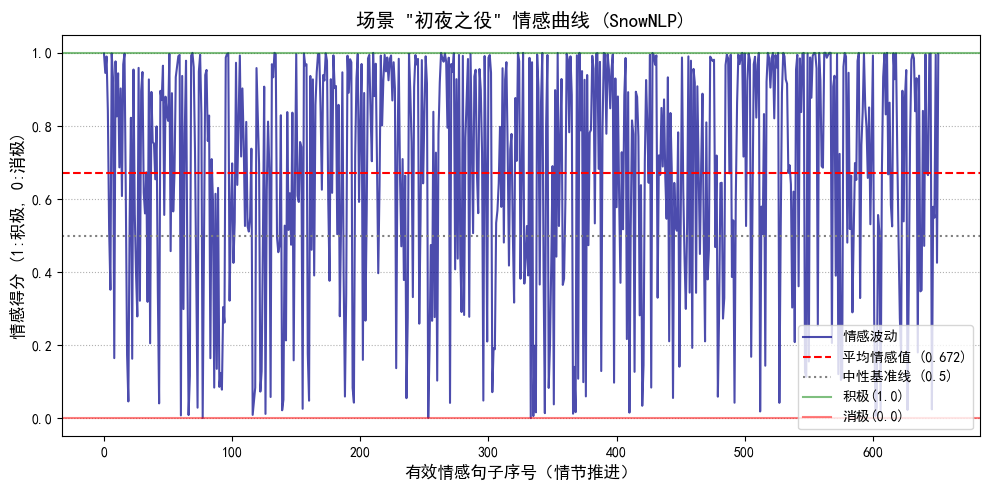


✅ 场景 '初夜之役' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.6715 (高于 0.5 倾向积极)


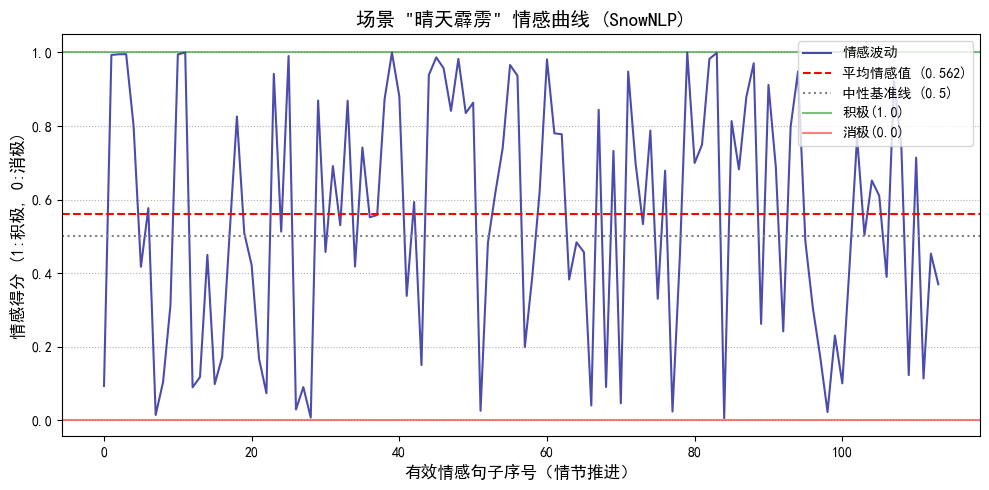


✅ 场景 '晴天霹雳' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.5617 (高于 0.5 倾向积极)


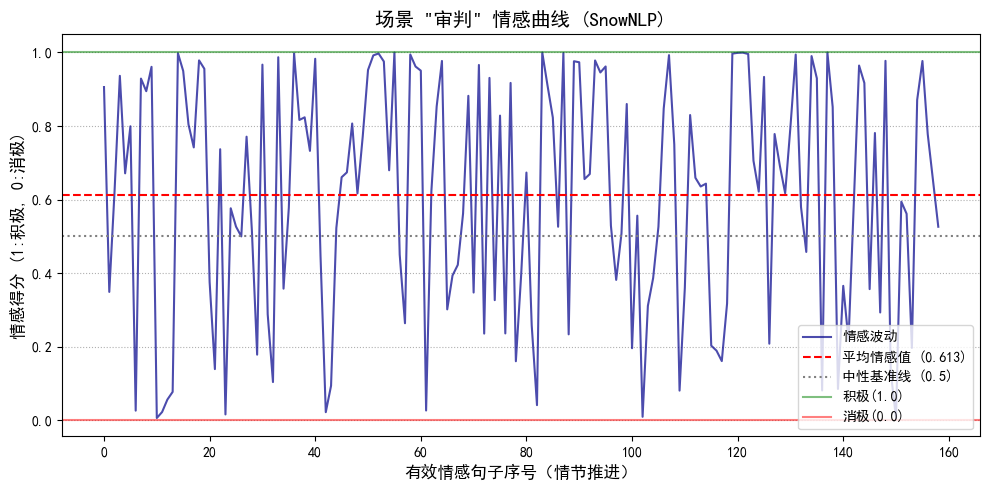


✅ 场景 '审判' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.6133 (高于 0.5 倾向积极)

✅ 场景情感分析结果已成功保存到文件: scene_sentiment_results.csv

--- 场景情感分析最终数据 ---
   场景名称  平均情感得分 (SnowNLP)   章节范围
0  初夜之役            0.6715  41-41
1  晴天霹雳            0.5617  41-41
2    审判            0.6133  41-41


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from snownlp import SnowNLP 

# --- 文件路径和输出设置 ---
file_path = 'hong_yu_hei_chapters_cleaned.csv' 
output_file = 'scene_sentiment_results.csv' # 定义输出文件名

# --- 1. 设置绘图参数 ---
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'FangSong'] 
plt.rcParams['axes.unicode_minus'] = False 

# --- 2. SnowNLP 情感计算函数 ---
def calculate_sentence_sentiment_snownlp(text):
    """使用 SnowNLP 计算情感得分 (0 到 1 之间)"""
    if not text: 
        return None
    s = SnowNLP(text)
    return s.sentiments

# --- 3. 分析与绘图函数 ---
def analyze_and_plot_scene(scene_name, text):
    # 此函数保持不变，但我们将返回 avg_score
    if not text:
        print(f"无法分析场景 '{scene_name}'，文本为空。")
        return None

    sentences = re.split(r'[。？！；]', text)
    scores = []
    
    for sentence in sentences:
        score = calculate_sentence_sentiment_snownlp(sentence)
        if score is not None: 
            scores.append(score)
    
    if not scores:
        print(f"场景 '{scene_name}' 中未分析到任何有效句子。")
        return None

    avg_score = np.mean(scores)
    
    # 绘图可视化部分... (保持不变)
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='情感波动', color='darkblue', alpha=0.7)
    plt.axhline(avg_score, color='red', linestyle='--', label=f'平均情感值 ({avg_score:.3f})')
    plt.axhline(0.5, color='gray', linestyle=':', label='中性基准线 (0.5)')
    plt.axhline(1.0, color='green', linestyle='-', alpha=0.5, label='积极(1.0)')
    plt.axhline(0.0, color='red', linestyle='-', alpha=0.5, label='消极(0.0)')
    plt.title(f'场景 "{scene_name}" 情感曲线 (SnowNLP)', fontsize=14)
    plt.xlabel('有效情感句子序号（情节推进）', fontsize=12)
    plt.ylabel('情感得分 (1:积极, 0:消极)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
    plt.show() 
    
    print(f"\n✅ 场景 '{scene_name}' 小说情感分析结果：")
    print(f"   - 场景平均情感得分 (SnowNLP): {avg_score:.4f} (高于 0.5 倾向积极)")
    
    return avg_score # 返回平均得分

# --- 4. 提取与运行主流程 ---
try:
    df = pd.read_csv(file_path)
    df['章节编号'] = pd.to_numeric(df['章节编号'], errors='coerce')
    df = df.dropna(subset=['章节编号'])
    df['文本长度'] = df['清洗后文本'].astype(str).apply(len)
    content_df = df[df['文本长度'] > 100]

    scene_params_final = {
        '初夜之役': {'卷名': '上卷', '范围': (9, 10)}, 
        '晴天霹雳': {'卷名': '下卷', '范围': (35, 35)}, 
        '审判': {'卷名': '下卷', '范围': (41, 41)}      
    }

    extracted_scenes = {}
    scene_results = [] # 初始化列表，用于收集结果
    print("--- 正在提取关键场景文本 ---")
    
    for scene_name, params in scene_params_final.items():
        juan_name = params['卷名']
        start_chap, end_chap = params['范围']
        
        scene_df = content_df[
            (content_df['卷名'] == juan_name) & 
            (content_df['章节编号'] >= start_chap) & 
            (content_df['章节编号'] <= end_chap)
        ]
        
        clean_text_list = scene_df['清洗后文本'].astype(str).tolist()
        clean_text_list = [t for t in clean_text_list if t != 'nan' and t != '']
        full_text = ' '.join(clean_text_list)
        extracted_scenes[scene_name] = full_text
        
        if full_text:
            print(f"✅ 成功提取 '{scene_name}' (章节 {start_chap}-{end_chap})，文本长度: {len(full_text)} 字。")
        else:
            print(f"❌ 失败提取 '{scene_name}'，请检查章节编号是否正确。")


    print("\n--- 正在生成情感分析结果和曲线 ---")
    for scene_name, text in extracted_scenes.items():
        avg_score = analyze_and_plot_scene(scene_name, text)
        
        # 将结果添加到列表中
        if avg_score is not None:
            scene_results.append({
                '场景名称': scene_name,
                '平均情感得分 (SnowNLP)': round(avg_score, 4),
                '章节范围': f"{start_chap}-{end_chap}"
            })

    # --- 5. 结果保存到文件 ---
    results_df = pd.DataFrame(scene_results)
    results_df.to_csv(output_file, index=False, encoding='utf_8_sig') # 使用 utf_8_sig 确保中文不乱码
    print(f"\n✅ 场景情感分析结果已成功保存到文件: {output_file}")
    
    # 打印最终结果供快速预览
    print("\n--- 场景情感分析最终数据 ---")
    print(results_df)

except FileNotFoundError:
    print(f"\n❌ 错误：找不到文件 '{file_path}'。请确保 CSV 文件与你的 Jupyter Notebook 在同一个目录下。")
except Exception as e:
    print(f"\n❌ 运行过程中发生错误: {e}")

--- 正在提取关键场景文本 ---
✅ 成功提取 '初夜之役' (章节 9-10)，文本长度: 18011 字。
✅ 成功提取 '晴天霹雳' (章节 35-35)，文本长度: 3042 字。
✅ 成功提取 '审判' (章节 41-41)，文本长度: 4692 字。

--- 正在生成情感分析结果和曲线 ---
✅ 图片已保存为: scene_初夜之役.png


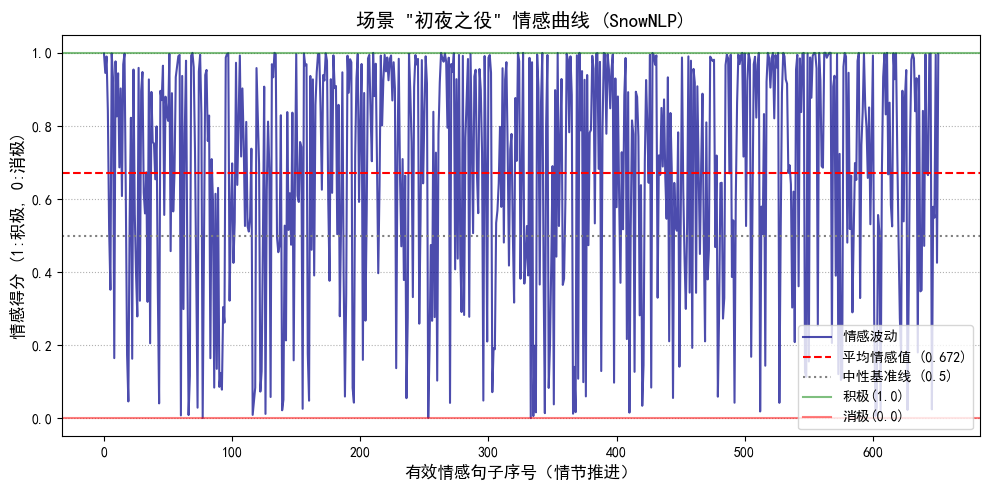


✅ 场景 '初夜之役' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.6715 (高于 0.5 倾向积极)
✅ 图片已保存为: scene_晴天霹雳.png


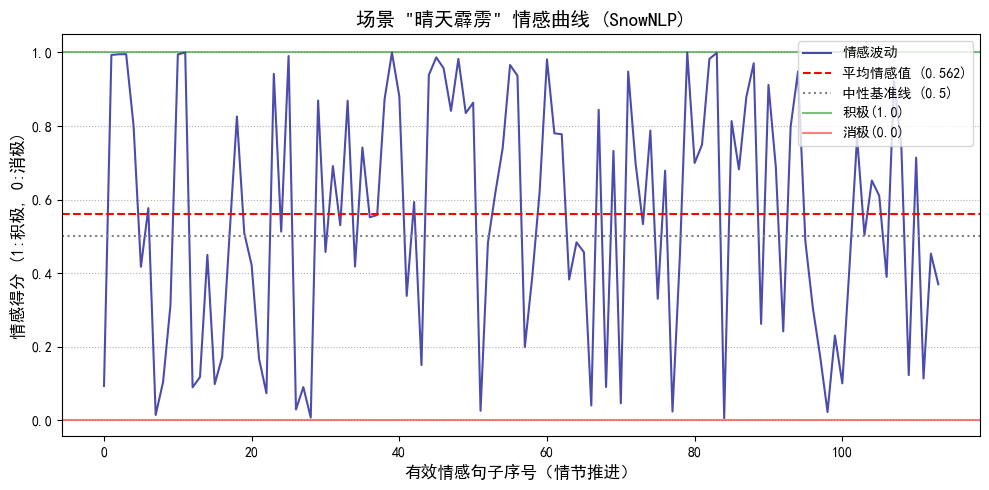


✅ 场景 '晴天霹雳' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.5617 (高于 0.5 倾向积极)
✅ 图片已保存为: scene_审判.png


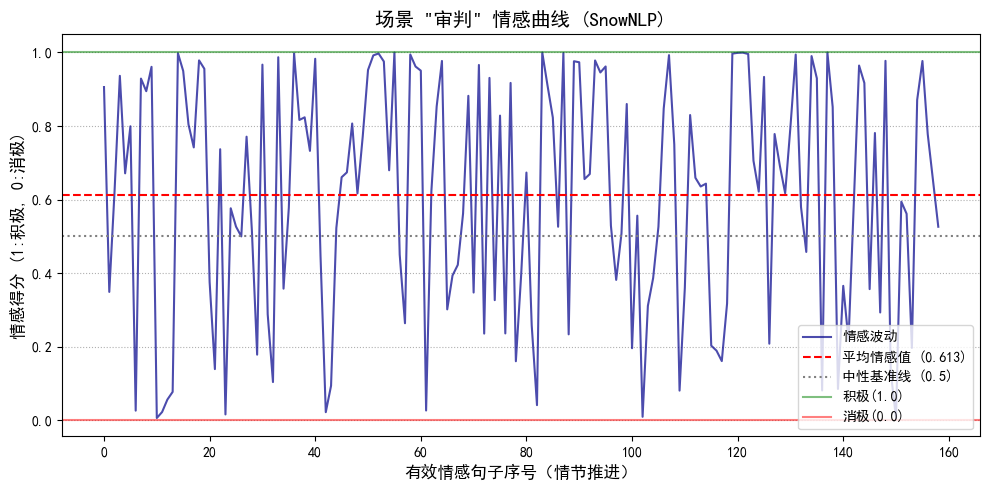


✅ 场景 '审判' 小说情感分析结果：
   - 场景平均情感得分 (SnowNLP): 0.6133 (高于 0.5 倾向积极)

✅ 场景情感分析结果已成功保存到文件: scene_sentiment_results.csv

--- 场景情感分析最终数据 ---
   场景名称  平均情感得分 (SnowNLP)   章节范围
0  初夜之役            0.6715  41-41
1  晴天霹雳            0.5617  41-41
2    审判            0.6133  41-41


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from snownlp import SnowNLP 

# --- 文件路径和输出设置 ---
file_path = 'hong_yu_hei_chapters_cleaned.csv' 
output_csv_file = 'scene_sentiment_results.csv' # CSV 输出文件名
image_output_prefix = 'scene_' # 图片文件名前缀

# --- 1. 设置绘图参数 ---
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'FangSong'] 
plt.rcParams['axes.unicode_minus'] = False 

# --- 2. SnowNLP 情感计算函数 ---
def calculate_sentence_sentiment_snownlp(text):
    """使用 SnowNLP 计算情感得分 (0 到 1 之间)"""
    if not text: 
        return None
    s = SnowNLP(text)
    return s.sentiments

# --- 3. 分析、绘图并保存函数 ---
def analyze_and_plot_scene(scene_name, text):
    if not text:
        print(f"无法分析场景 '{scene_name}'，文本为空。")
        return None

    sentences = re.split(r'[。？！；]', text)
    scores = []
    
    for sentence in sentences:
        score = calculate_sentence_sentiment_snownlp(sentence)
        if score is not None: 
            scores.append(score)
    
    if not scores:
        print(f"场景 '{scene_name}' 中未分析到任何有效句子。")
        return None

    avg_score = np.mean(scores)
    
    # 绘图可视化
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='情感波动', color='darkblue', alpha=0.7)
    plt.axhline(avg_score, color='red', linestyle='--', label=f'平均情感值 ({avg_score:.3f})')
    plt.axhline(0.5, color='gray', linestyle=':', label='中性基准线 (0.5)')
    plt.axhline(1.0, color='green', linestyle='-', alpha=0.5, label='积极(1.0)')
    plt.axhline(0.0, color='red', linestyle='-', alpha=0.5, label='消极(0.0)')
    plt.title(f'场景 "{scene_name}" 情感曲线 (SnowNLP)', fontsize=14)
    plt.xlabel('有效情感句子序号（情节推进）', fontsize=12)
    plt.ylabel('情感得分 (1:积极, 0:消极)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
    
    # 🚨 关键步骤：保存图片文件
    image_filename = f"{image_output_prefix}{scene_name}.png"
    plt.savefig(image_filename, dpi=300) # 保存为 PNG 格式，300dpi 确保高分辨率
    print(f"✅ 图片已保存为: {image_filename}")
    
    plt.show() # 在 Notebook 中显示图表
    
    print(f"\n✅ 场景 '{scene_name}' 小说情感分析结果：")
    print(f"   - 场景平均情感得分 (SnowNLP): {avg_score:.4f} (高于 0.5 倾向积极)")
    
    return avg_score # 返回平均得分

# --- 4. 提取与运行主流程 ---
try:
    df = pd.read_csv(file_path)
    df['章节编号'] = pd.to_numeric(df['章节编号'], errors='coerce')
    df = df.dropna(subset=['章节编号'])
    df['文本长度'] = df['清洗后文本'].astype(str).apply(len)
    content_df = df[df['文本长度'] > 100]

    scene_params_final = {
        '初夜之役': {'卷名': '上卷', '范围': (9, 10)}, 
        '晴天霹雳': {'卷名': '下卷', '范围': (35, 35)}, 
        '审判': {'卷名': '下卷', '范围': (41, 41)}      
    }

    extracted_scenes = {}
    scene_results = [] 
    print("--- 正在提取关键场景文本 ---")
    
    for scene_name, params in scene_params_final.items():
        juan_name = params['卷名']
        start_chap, end_chap = params['范围']
        
        scene_df = content_df[
            (content_df['卷名'] == juan_name) & 
            (content_df['章节编号'] >= start_chap) & 
            (content_df['章节编号'] <= end_chap)
        ]
        
        clean_text_list = scene_df['清洗后文本'].astype(str).tolist()
        clean_text_list = [t for t in clean_text_list if t != 'nan' and t != '']
        full_text = ' '.join(clean_text_list)
        extracted_scenes[scene_name] = full_text
        
        if full_text:
            print(f"✅ 成功提取 '{scene_name}' (章节 {start_chap}-{end_chap})，文本长度: {len(full_text)} 字。")
        else:
            print(f"❌ 失败提取 '{scene_name}'，请检查章节编号是否正确。")


    print("\n--- 正在生成情感分析结果和曲线 ---")
    for scene_name, text in extracted_scenes.items():
        avg_score = analyze_and_plot_scene(scene_name, text)
        
        # 将结果添加到列表中
        if avg_score is not None:
            scene_results.append({
                '场景名称': scene_name,
                '平均情感得分 (SnowNLP)': round(avg_score, 4),
                '章节范围': f"{start_chap}-{end_chap}"
            })

    # --- 5. 结果保存到文件 ---
    results_df = pd.DataFrame(scene_results)
    results_df.to_csv(output_csv_file, index=False, encoding='utf_8_sig') 
    print(f"\n✅ 场景情感分析结果已成功保存到文件: {output_csv_file}")
    
    print("\n--- 场景情感分析最终数据 ---")
    print(results_df)

except FileNotFoundError:
    print(f"\n❌ 错误：找不到文件 '{file_path}'。请确保 CSV 文件与你的 Jupyter Notebook 在同一个目录下。")
except Exception as e:
    print(f"\n❌ 运行过程中发生错误: {e}")